# Seps Tutorial Follow Along

Here we will follow the tutorial on https://sep.readthedocs.io/en/v1.0.x/tutorial.html, but using  `astropy.io.fits` package instead of the `fitsio` package used there.
This tutorial shows the basic steps of using SEP to detect objects in an image and perform some basic aperture photometry.

## Install and import relevant libraries

In [2]:
#Install uncommon libraries if necessary
#!pip install astropy
#!pip install sep

In [3]:
import numpy as np
import sep

In [4]:
# additional setup for reading the test image and displaying plots
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

## Import Data and Preliminary Plot

Read in an example image from a FITS file and display it

In [4]:
%%capture --no-stderr
#to stop the warning
# read image into standard 2-d numpy array
data = fits.open("image.fits")[0].data

ESO-LOG 00:00:00> DATE         = '1992-10-26'  / Mon Oct 26, 1992                [astropy.io.fits.card]
ESO-LOG 03:04:08>-START EXPO EMMI RED          / Start exp. on EMMI Red CC       [astropy.io.fits.card]
ESO-LOG 03:04:09> EXPO EMMI RED NO = 24887     / Exp. num. on EMMI Red CCD       [astropy.io.fits.card]
ESO-LOG 03:10:52>-STOP EXPO EMMI RED           / Stop exp. on EMMI Red CCD       [astropy.io.fits.card]


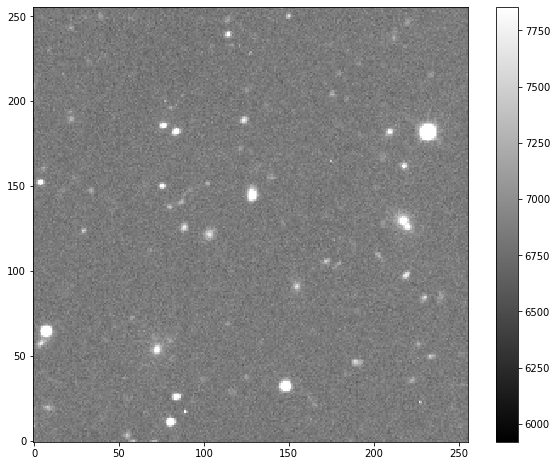

In [5]:
# show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
plt.savefig('tutorial_initialimage.png')

## Background subtraction

This optical/IR data must be background subtracted before sources can be detected.

### Background estimation

In [6]:
# measure a spatially varying background on the image
bkg = sep.Background(data)

This returns an `Background` object that holds information on the spatially varying background and spatially varying background noise level.  We can now do various things with this `Background` object:

In [7]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

6852.04931640625
65.46174621582031


In [8]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

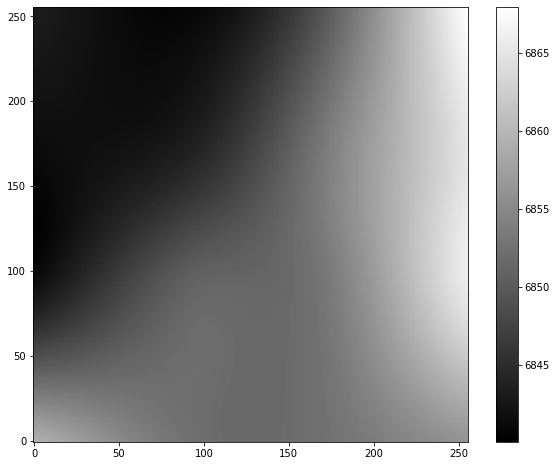

In [9]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('tutorial_bg.png')

In [ ]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

In [ ]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('tutorial_bgnoise.png')

### Background subtraction

In [ ]:
# subtract the background
data_sub = data - bkg


## Object detection

With a subtracted background object detection can now be run on the data.
Noting a flat background noise level we can set the detection threshold to a constand value of 1.5 $\sigma$ where $\sigma$ is the global background RMS.

In [ ]:
#place all identified object into an array
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

In [ ]:
#just to take a look at an object
objects[:1]

In [ ]:
# how many objects were detected
len(objects)

`objects['x']` and `objects['y']`  give the centroid coordinates of the objects.
Jere we plot the detected shapes on the objects with the original image as a sanity check.

In [ ]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

plt.savefig('tutorial_plotwithobjects.png')

In [ ]:
# These are the other fields available on the objects
objects.dtype.names

## Aperture photometry

Here we perform simple circular aperture photometry with a 3 pixel radius at the locations of the objects:

In [ ]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

`flux`, `fluxerr` and `flag` are all 1-d arrays with one entry per object.

In [ ]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))